In [1]:
import subprocess
from IPython.display import display
command = ["/home/yutao/project/aiida/applications/sample.sh"]
# Run the script using subprocess
completed_process = subprocess.run(command, capture_output=True, cwd="/home/yutao/project/aiida/applications",text=True)

# Check the return code
if completed_process.returncode == 0:
    # The script finished successfully
    display("Script finished successfully!")
    # Display the output in the notebook
    display("Script output:")
    display(completed_process.stdout)
    # Continue with your program logic here
else:
    # The script encountered an error
    print("Script encountered an error:", completed_process.stderr)
    display("Script encountered an error:", completed_process.stderr)
    # Handle the error or exit the program


KeyboardInterrupt: 

This is a copy version of UFF force field optimization  process
# Remember to change the name of process file.
orginal traj
/MIL/traj
ff_*.json

In [1]:
# These package is inherited from Lenard-Jones optimization part of DMFF

import openmm.app as app
import openmm as mm
import openmm.unit as unit
import numpy as np
import jax
import jax.numpy as jnp
import dmff
from dmff.api.xmlio import XMLIO
from dmff.api.paramset import ParamSet
from dmff.generators.classical import CoulombGenerator, LennardJonesGenerator
from dmff.api.hamiltonian import Hamiltonian
from dmff.operators import ParmedLennardJonesOperator
from dmff import NeighborListFreud
from dmff.mbar import ReweightEstimator
import mdtraj as md
from tqdm import tqdm, trange
import parmed
import sys
import os
from dmff.api.topology import DMFFTopology
# this is a package I write to solve some IO problems utils.py
from utils import create_supercell, gas_generate,add_loading, simple_merge
from utils import cutoff_topology
import matplotlib.pyplot as plt
import optax
from utils import extract_from_raspa

Warning on use of the timeseries module: If the inherent timescales of the system are long compared to those being analyzed, this statistical inefficiency may be an underestimate.  The estimate presumes the use of many statistically independent samples.  Tests should be performed to assess whether this condition is satisfied.   Be cautious in the interpretation of the data.


In [2]:
"""

Superparameters for Lenard-Jone Potential optimization

"""
Number_points = 7             ## must be smaller than len(picked_ls)
Trajectory_length = 250#250          #液体pdb文件的个数
target_site1 = -50.60                  #拟合的目标binding energy
target_site2 = -46.69           #拟合的目标binding energy
SET_temperature=  100           #温度设定
time_gap=   2.2                      #分子动力学模拟过程中每一个frame的时间间隔，单位是皮秒picosecond   推荐2-4ps
loop_time =   100                  #迭代循环次数    推荐50-100
scaling_factors = (3,3,2)
cutoff = 0.905     #1.3 # unit is nanometer

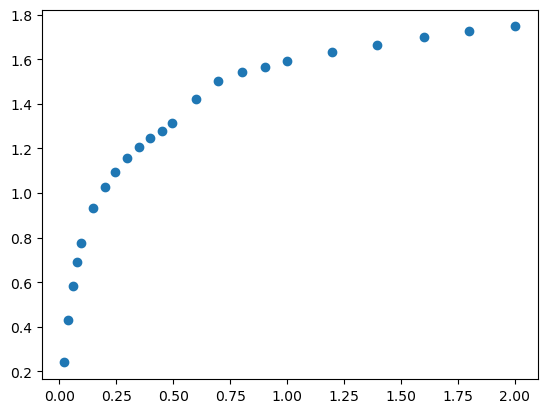

In [3]:
Transfer_unit = 2.7719416667/5.6100437023 



pressure_list = [
            0.021648873072361,
            0.038256227758007,
            0.059015421115065,
            0.077698695136418,
            0.09638196915777,
            0.14827995255042,
            0.20017793594306,
            0.24584816132859,
            0.29774614472123,
            0.34756820877817,
            0.39739027283511,
            0.44928825622776,
            0.49495848161329,
            0.60083036773428,
            0.69839857651246,
            0.80219454329775,
            0.90183867141163,
            0.99733096085409,
            1.1986951364176,
            1.3959074733096,
            1.5993475682088,
            1.7986358244365,
            2.0020759193357
        ]

arr_3 = np.loadtxt("/home/yutao/dataset/exp_303.txt", delimiter=',')
plt.scatter(arr_3[:,0], Transfer_unit*arr_3[:,1], label = r"303K experiments")

picked_ls = [0, 3, 6, 9, 12, 15, 18]
picked_pressure = [pressure_list[i] for i in picked_ls]
picked_isotherm = [arr_3[i,1]*Transfer_unit for i in picked_ls]

def is_close_to_list(value, value_list):
    for list_value in value_list:
        relative_error = abs((value - list_value) / list_value)
        if relative_error < 0.01:
            return 1
    return 0

In [4]:
import os
import numpy as np
from utils import scaling_gas, extract_from_raspa, write_scaling_gas
bar = 10**5
def move_traj(dest_path = "/home/yutao/project/MIL-120/traj1/",picked_pressure=picked_pressure, copy_to_path = "./traj1/"):
    traj_ls = os.listdir(dest_path)
    isotherm_data = [[],[]] # the first list is for pressure, the second is for loading
    jdx = 0 
    for traj in extract_from_raspa(traj_ls):
        pdb_file = traj[1]
        if not pdb_file.endswith(".pdb") or 'Movie_framework' not in pdb_file:
            continue
        if not is_close_to_list(float(traj[0])/bar, picked_pressure):
            continue
        isotherm_data[0].append(float(traj[0])/bar)
        pdb_path = os.path.join(dest_path, pdb_file)
        with open(pdb_path) as f:
            lines = f.readlines()
        num_atoms_list = []  # List to store the number of atoms in each structure
        index = 0
        write_idx = 1
        num_atoms = 0  # Variable to store the number of atoms in the current structure
        directory = copy_to_path+f"{jdx+1}"
        jdx += 1
        if not os.path.exists(directory):
            os.makedirs(directory)
            print("Directory created:", directory)
        for line in lines:
            if line.startswith("MODEL"):
                if index>=150:
                    write_scaling_gas(block_coords, "data/gas.pdb", write_idx, dest_path=directory)
                    write_idx += 1
                block_coords = []
                block_Csym = []
                index += 1
                num_atoms_list.append(num_atoms)  # Add the number of atoms to the list
                num_atoms = 0  # Reset the number of atoms for the next structure
            if line.startswith("ATOM"):
                parts = line.split()
                coords = np.array([float(parts[4]), float(parts[5]), float(parts[6])])
                block_coords.append(coords)
                block_Csym.append(parts[-1])
                num_atoms += 1  # Increment the number of atoms
        #num_atoms_list.append(num_atoms)  # Add the number of atoms for the last structure
        isotherm_data[1].append(sum(num_atoms_list)/len(num_atoms_list)/3/3/2/3)
        #print("Number of atoms in each structure for", pdb_file, ":", num_atoms_list)
    return isotherm_data

In [5]:
def update_mask(parameters, mask):
    updated_parameters = parameters.copy()
    
    for force_type, force_params in mask.items():
        if force_type in parameters:
            for param, mask_array in force_params.items():
                if param in parameters[force_type]:
                    # Update values based on the mask
                    updated_parameters[force_type][param] = jnp.where(mask_array == 1, 
                                                                      parameters[force_type][param], 
                                                                      0)
    return updated_parameters

def compute_binding_energy(paramset,topo, pos, lj_gen, numframe=720,cutoff=cutoff):
    topodata = dmff.DMFFTopology(topo)
    # Because dmfftopology does not provide a good entry for open.topology object generated by pdb file, I had to suplement something
    for atom in topodata.atoms():
        if atom.residue.name=="MOL":
            atom.meta['type']=atom.meta['element']
            atom.meta['class']=atom.meta['element']
        elif atom.residue.name=="GAS":
            #print(atom.meta)
            atom.meta['type']=atom.meta['element']+"_co2"
            atom.meta['class']=atom.meta['element']+"_co2"
        #print(atom.meta['element'])
    cov_mat = topodata.buildCovMat()
    lj_force = lj_gen.createPotential(
    topodata, nonbondedMethod=app.PME, nonbondedCutoff=cutoff, args={})
    pos_jnp = jnp.array(pos.value_in_unit(unit.nanometer))
    cell_jnp = jnp.array(topo.getPeriodicBoxVectors().value_in_unit(unit.nanometer))
    cov_mat=cov_mat.at[:numframe,:numframe].set(1)
    nblist = NeighborListFreud(topo.getPeriodicBoxVectors().value_in_unit(unit.nanometer), cutoff, cov_mat)
    nblist.allocate(pos_jnp, cell_jnp)
    pairs = jnp.array(nblist.pairs)
    ener = lj_force(pos_jnp,cell_jnp, pairs, paramset)
    return ener

In [6]:
# Initial Optimized parameters
xmlio = XMLIO()
xmlio.loadXML("data/init.xml")
ffinfo = xmlio.parseXML()
paramset = ParamSet()
lj_gen = LennardJonesGenerator(ffinfo, paramset)
paramset.mask['LennardJonesForce']['sigma'] = paramset.mask['LennardJonesForce']['sigma'].at[0].set(0)
paramset.mask['LennardJonesForce']['sigma'] = paramset.mask['LennardJonesForce']['sigma'].at[1].set(0)
paramset.mask['LennardJonesForce']['sigma'] = paramset.mask['LennardJonesForce']['sigma'].at[2].set(0)
paramset.mask['LennardJonesForce']['sigma'] = paramset.mask['LennardJonesForce']['sigma'].at[3].set(0)

In [7]:
'''

traj_dict = {}

# I have alreay generated a trajectory example
dest_path = "./traj/"
traj_ls = os.listdir(dest_path)
create_supercell("data/MIL-120.pdb", scaling_factors, "scaled_frame.pdb")
ff = app.ForceField("custom_forcefield.xml")

# Filter out file names and keep only directory names
dir_names = [name for name in traj_ls if os.path.isdir(os.path.join(dest_path, name)) and name.isdigit()]

for directory in dir_names[:1]:
    idx = int(directory)
    traj_dict[idx] = {'experiment': {'pressure': picked_pressure[idx-1], 'loading': picked_isotherm[idx-1]}, 'structure': [], 'refer_energy':[], 'loading':[]}
    gas_dir = os.path.join(dest_path, directory)
    for gas_path in os.listdir(gas_dir)[::3]:
        topo, pos, num = simple_merge("scaled_frame.pdb",os.path.join(gas_dir,gas_path))
        ener_lj = compute_binding_energy(paramset,topo, pos, lj_gen, numframe=720,cutoff=cutoff)
        traj_dict[idx]['structure'].append([topo, pos])
        traj_dict[idx]['loading'].append(num/scaling_factors[0]/scaling_factors[1]/scaling_factors[2]/3)
        traj_dict[idx]['refer_energy'].append(ener_lj)
for key in traj_dict.keys():
    traj_dict[key]['refer_energy'] = jnp.array(traj_dict[key]['refer_energy'])
    traj_dict[key]['loading'] = jnp.array(traj_dict[key]['loading'])
    traj_dict[key]['estimator'] = ReweightEstimator(ref_energies=traj_dict[key]['refer_energy'], temperature=SET_temperature)
'''

'\n\ntraj_dict = {}\n\n# I have alreay generated a trajectory example\ndest_path = "./traj/"\ntraj_ls = os.listdir(dest_path)\ncreate_supercell("data/MIL-120.pdb", scaling_factors, "scaled_frame.pdb")\nff = app.ForceField("custom_forcefield.xml")\n\n# Filter out file names and keep only directory names\ndir_names = [name for name in traj_ls if os.path.isdir(os.path.join(dest_path, name)) and name.isdigit()]\n\nfor directory in dir_names[:1]:\n    idx = int(directory)\n    traj_dict[idx] = {\'experiment\': {\'pressure\': picked_pressure[idx-1], \'loading\': picked_isotherm[idx-1]}, \'structure\': [], \'refer_energy\':[], \'loading\':[]}\n    gas_dir = os.path.join(dest_path, directory)\n    for gas_path in os.listdir(gas_dir)[::3]:\n        topo, pos, num = simple_merge("scaled_frame.pdb",os.path.join(gas_dir,gas_path))\n        ener_lj = compute_binding_energy(paramset,topo, pos, lj_gen, numframe=720,cutoff=cutoff)\n        traj_dict[idx][\'structure\'].append([topo, pos])\n        tra

In [8]:

def compute_binding_energy(paramset,topo, pos, lj_gen, numframe=720,cutoff=cutoff):
    topodata = dmff.DMFFTopology(topo)
    # Because dmfftopology does not provide a good entry for open.topology object generated by pdb file, I had to suplement something
    for atom in topodata.atoms():
        if atom.residue.name=="MOL":
            atom.meta['type']=atom.meta['element']
            atom.meta['class']=atom.meta['element']
        elif atom.residue.name=="GAS":
            #print(atom.meta)
            atom.meta['type']=atom.meta['element']+"_co2"
            atom.meta['class']=atom.meta['element']+"_co2"
        #print(atom.meta['element'])
    cov_mat = topodata.buildCovMat()
    lj_force = lj_gen.createPotential(
    topodata, nonbondedMethod=app.PME, nonbondedCutoff=cutoff, args={})
    pos_jnp = jnp.array(pos.value_in_unit(unit.nanometer))
    cell_jnp = jnp.array(topo.getPeriodicBoxVectors().value_in_unit(unit.nanometer))
    cov_mat=cov_mat.at[:numframe,:numframe].set(1)
    nblist = NeighborListFreud(topo.getPeriodicBoxVectors().value_in_unit(unit.nanometer), cutoff, cov_mat)
    nblist.allocate(pos_jnp, cell_jnp)
    pairs = jnp.array(nblist.pairs)
    ener = lj_force(pos_jnp,cell_jnp, pairs, paramset)
    return ener

In [10]:
'''
traj_dict = {}
global Number_points, cutoff
traj_ls = os.listdir(dest_path)
create_supercell("data/MIL-120.pdb", scaling_factors, "scaled_frame.pdb")

# Filter out file names and keep only directory names
dir_names = [name for name in traj_ls if os.path.isdir(os.path.join(dest_path, name)) and name.isdigit()]

for directory in dir_names[:Number_points]:
    idx = int(directory)
    traj_dict[idx] = {'experiment': {'pressure': picked_pressure[idx-1], 'loading': picked_isotherm[idx-1]}, 'structure': [], 'refer_energy':[], 'loading':[]}
    gas_dir = os.path.join(dest_path, directory)
    for gas_path in os.listdir(gas_dir)[::10]:
        topo, pos, num = simple_merge("scaled_frame.pdb",os.path.join(gas_dir,gas_path))
        ener_lj = compute_binding_energy(paramset,topo, pos, lj_gen, numframe=720,cutoff=cutoff)
        traj_dict[idx]['structure'].append([topo, pos])
        traj_dict[idx]['loading'].append(num/scaling_factors[0]/scaling_factors[1]/scaling_factors[2]/3)
        traj_dict[idx]['refer_energy'].append(ener_lj)
for key in traj_dict.keys():
    traj_dict[key]['refer_energy'] = jnp.array(traj_dict[key]['refer_energy'])
    traj_dict[key]['loading'] = jnp.array(traj_dict[key]['loading'])
    traj_dict[key]['estimator'] = ReweightEstimator(ref_energies=traj_dict[key]['refer_energy'], temperature=SET_temperature)
'''

'\ntraj_dict = {}\nglobal Number_points, cutoff\ntraj_ls = os.listdir(dest_path)\ncreate_supercell("data/MIL-120.pdb", scaling_factors, "scaled_frame.pdb")\n\n# Filter out file names and keep only directory names\ndir_names = [name for name in traj_ls if os.path.isdir(os.path.join(dest_path, name)) and name.isdigit()]\n\nfor directory in dir_names[:Number_points]:\n    idx = int(directory)\n    traj_dict[idx] = {\'experiment\': {\'pressure\': picked_pressure[idx-1], \'loading\': picked_isotherm[idx-1]}, \'structure\': [], \'refer_energy\':[], \'loading\':[]}\n    gas_dir = os.path.join(dest_path, directory)\n    for gas_path in os.listdir(gas_dir)[::10]:\n        topo, pos, num = simple_merge("scaled_frame.pdb",os.path.join(gas_dir,gas_path))\n        ener_lj = compute_binding_energy(paramset,topo, pos, lj_gen, numframe=720,cutoff=cutoff)\n        traj_dict[idx][\'structure\'].append([topo, pos])\n        traj_dict[idx][\'loading\'].append(num/scaling_factors[0]/scaling_factors[1]/scal

In [42]:
from jax._src.api import clear_backends

In [33]:
def analyse_traj(paramset, lj_gen, dest_path = "./traj1/", interval=3):
    traj_dict = {}
    global Number_points, cutoff
    traj_ls = os.listdir(dest_path)
    create_supercell("data/MIL-120.pdb", scaling_factors, "scaled_frame.pdb")

    # Filter out file names and keep only directory names
    dir_names = [name for name in traj_ls if os.path.isdir(os.path.join(dest_path, name)) and name.isdigit()]

    for directory in dir_names[:Number_points]:
        idx = int(directory)
        traj_dict[idx] = {'experiment': {'pressure': picked_pressure[idx-1], 'loading': picked_isotherm[idx-1]}, 'structure': [], 'refer_energy':[], 'loading':[]}
        gas_dir = os.path.join(dest_path, directory)
        for gas_path in os.listdir(gas_dir)[::interval]:
            topo, pos, num = simple_merge("scaled_frame.pdb",os.path.join(gas_dir,gas_path))
            ener_lj = compute_binding_energy(paramset,topo, pos, lj_gen, numframe=720,cutoff=cutoff)
            traj_dict[idx]['structure'].append([topo, pos])
            traj_dict[idx]['loading'].append(num/scaling_factors[0]/scaling_factors[1]/scaling_factors[2]/3)
            traj_dict[idx]['refer_energy'].append(ener_lj)
        clear_backends()
    for key in traj_dict.keys():
        traj_dict[key]['refer_energy'] = jnp.array(traj_dict[key]['refer_energy'])
        traj_dict[key]['loading'] = jnp.array(traj_dict[key]['loading'])
        traj_dict[key]['estimator'] = ReweightEstimator(ref_energies=traj_dict[key]['refer_energy'], temperature=SET_temperature)
    return traj_dict

In [12]:
import subprocess
def sample():
    command = ["/home/yutao/project/aiida/applications/sample_long.sh"]
    # Run the script using subprocess
    completed_process = subprocess.run(command, capture_output=True, cwd="/home/yutao/project/aiida/applications",text=True)

    # Check the return code
    if completed_process.returncode == 0:
        # The script finished successfully
        display("Script finished successfully!")
        # Display the output in the notebook
        display("Script output:")
        display(completed_process.stdout)
        # Continue with your program logic here
    else:
        # The script encountered an error
        display("Script encountered an error:", completed_process.stderr)
        # Handle the error or exit the program

In [13]:
import optax
optimizer = optax.adam(0.005)
opt_state = optimizer.init(paramset)

In [14]:
import json
Transfer_energy_unit = 254.152/2.11525
Transfer_length_unit = 10
def update_ff(paramset, dest_path='/home/yutao/project/aiida/applications/ff_2.json'):
    global Transfer_energy_unit, Transfer_length_unit
    element_list = ['Al_', 'C_', 'H_', 'O_']
    params = paramset.parameters
    ff_data = {}
    if len(element_list) != params['LennardJonesForce']['sigma'].shape[0]-2:
        raise ValueError("Length of element list and parameter list does not match")
    sigma_list = params['LennardJonesForce']['sigma'].tolist()
    epsilon_list = params['LennardJonesForce']['epsilon'].tolist()
    for idx in range(len(element_list)):
        ff_data[element_list[idx]] = ['lennard-jones', epsilon_list[idx]*Transfer_energy_unit, sigma_list[idx]*Transfer_length_unit]
    with open(dest_path, 'w') as f:
        json.dump(ff_data, f, indent=4)

In [20]:
from jax._src.api import clear_backends

In [45]:

loss_ls = []
os.system("cp /home/yutao/project/aiida/applications/UFF.json /home/yutao/project/aiida/applications/ff_2.json")

for nloop in range(1,80):
    print(f"This is {nloop} time")
    if nloop % 5 == 0:
        sample()
    move_traj(dest_path="/home/yutao/project/MIL-120/traj1/",picked_pressure=picked_pressure, copy_to_path = "./traj1/")
    traj_dict = analyse_traj(paramset, lj_gen, dest_path="./traj1/", interval=4)
    def loss(paramset):
        errors = []
        for idx in range(1, Number_points+1):
            energies = []
            for jdx in range(len(traj_dict[idx]['structure'])):
                ener = compute_binding_energy(paramset, traj_dict[idx]['structure'][jdx][0], traj_dict[idx]['structure'][jdx][1], lj_gen, numframe=720,cutoff=cutoff)
                energies.append(ener.reshape((1,)))
            energies = jnp.concatenate(energies)
            weight = traj_dict[idx]['estimator'].estimate_weight(energies)
            reweight_loading = traj_dict[idx]['loading'] * weight
            error = jnp.power(jnp.average(reweight_loading)-traj_dict[idx]['experiment']['loading'],2)
            errors.append(error.reshape((1,)))
            #print(error)
        errors = jnp.concatenate(errors)
        return jnp.sum(errors)

    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    loss_ls.append(v)
    
    updates, opt_state = optimizer.update(g, opt_state)
    updates.parameters = update_mask(updates.parameters,paramset.mask)
    paramset = optax.apply_updates(paramset, updates)
    paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
    update_ff(paramset, dest_path='/home/yutao/project/aiida/applications/ff_2.json')
    lj_gen.overwrite(paramset)
    clear_backends()


This is 1 time


JIT session error: Cannot allocate memory


XlaRuntimeError: INVALID_ARGUMENT: Symbol main.4 not found.

In [ ]:
v, g = v_and_g(paramset)

In [26]:
np.zeros((800,800))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [41]:
clear_backends()

In [40]:
for nloop in range(1,80):
    print(f"This is {nloop} time")
    if nloop % 5 == 0:
        sample()
    move_traj(dest_path="/home/yutao/project/MIL-120/traj1/",picked_pressure=picked_pressure, copy_to_path = "./traj1/")
    traj_dict = analyse_traj(paramset, lj_gen, dest_path="./traj1/", interval=10)
    def loss(paramset):
        errors = []
        for idx in range(1, Number_points+1):
            energies = []
            for jdx in range(len(traj_dict[idx]['structure'])):
                ener = compute_binding_energy(paramset, traj_dict[idx]['structure'][jdx][0], traj_dict[idx]['structure'][jdx][1], lj_gen, numframe=720,cutoff=cutoff)
                energies.append(ener.reshape((1,)))
            energies = jnp.concatenate(energies)
            weight = traj_dict[idx]['estimator'].estimate_weight(energies)
            reweight_loading = traj_dict[idx]['loading'] * weight
            error = jnp.power(jnp.average(reweight_loading)-traj_dict[idx]['experiment']['loading'],2)
            errors.append(error.reshape((1,)))
            #print(error)
        errors = jnp.concatenate(errors)
        return jnp.sum(errors)

    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    loss_ls.append(v)
    
    updates, opt_state = optimizer.update(g, opt_state)
    updates.parameters = update_mask(updates.parameters,paramset.mask)
    paramset = optax.apply_updates(paramset, updates)
    paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
    update_ff(paramset, dest_path='/home/yutao/project/aiida/applications/ff_2.json')
    lj_gen.overwrite(paramset)
    

1

In [29]:
clear_backends()

In [34]:
for i in range(80):
    traj_dict = analyse_traj(paramset, lj_gen, dest_path="./traj1/", interval=10)
    print(len(traj_dict[1]['structure']))

25
25
25
25
25
25


KeyboardInterrupt: 

In [38]:
clear_backends()

In [39]:
def loss(paramset):
        errors = []
        for idx in range(1, Number_points+1):
            energies = []
            for jdx in range(len(traj_dict[idx]['structure'])):
                ener = compute_binding_energy(paramset, traj_dict[idx]['structure'][jdx][0], traj_dict[idx]['structure'][jdx][1], lj_gen, numframe=720,cutoff=cutoff)
                energies.append(ener.reshape((1,)))
            energies = jnp.concatenate(energies)
            weight = traj_dict[idx]['estimator'].estimate_weight(energies)
            reweight_loading = traj_dict[idx]['loading'] * weight
            error = jnp.power(jnp.average(reweight_loading)-traj_dict[idx]['experiment']['loading'],2)
            errors.append(error.reshape((1,)))
            #print(error)
        errors = jnp.concatenate(errors)
        return jnp.sum(errors)
v_and_g = jax.value_and_grad(loss, 0)
v, g = v_and_g(paramset)
loss_ls.append(v)

JIT session error: Cannot allocate memory


XlaRuntimeError: INVALID_ARGUMENT: Symbol main.4 not found.

In [53]:
clear_backends()
def loss(paramset):
        errors = []
        for idx in range(1, Number_points+1):
            energies = []
            for jdx in range(int(len(traj_dict[idx]['structure']))):
                ener = compute_binding_energy(paramset, traj_dict[idx]['structure'][jdx][0], traj_dict[idx]['structure'][jdx][1], lj_gen, numframe=720,cutoff=cutoff)
                energies.append(ener.reshape((1,)))
            energies = jnp.concatenate(energies)
            weight = traj_dict[idx]['estimator'].estimate_weight(energies)
            reweight_loading = traj_dict[idx]['loading'] * weight
            error = jnp.power(jnp.average(reweight_loading)-traj_dict[idx]['experiment']['loading'],2)
            errors.append(error.reshape((1,)))
            #print(error)
        errors = jnp.concatenate(errors)
        return jnp.sum(errors)
clear_backends()
v_and_g = jax.value_and_grad(loss, 0)
v, g = v_and_g(paramset)
loss_ls.append(v)

JIT session error: Cannot allocate memory


XlaRuntimeError: INVALID_ARGUMENT: Symbol main.4 not found.

In [51]:
for nloop in range(20):
    #move_traj(dest_path="/home/yutao/project/MIL-120/traj1/",picked_pressure=picked_pressure, copy_to_path = "./traj1/")
    #traj_dict = analyse_traj(paramset, lj_gen, dest_path="./traj1/", interval=20)
    #clear_backends()
    clear_backends()
    def loss(paramset):
        errors = []
        for idx in range(1, Number_points+1):
            energies = []
            for jdx in range(int(len(traj_dict[idx]['structure']))):
                ener = compute_binding_energy(paramset, traj_dict[idx]['structure'][jdx][0], traj_dict[idx]['structure'][jdx][1], lj_gen, numframe=720,cutoff=cutoff)
                energies.append(ener.reshape((1,)))
            energies = jnp.concatenate(energies)
            weight = traj_dict[idx]['estimator'].estimate_weight(energies)
            reweight_loading = traj_dict[idx]['loading'] * weight
            error = jnp.power(jnp.average(reweight_loading)-traj_dict[idx]['experiment']['loading'],2)
            errors.append(error.reshape((1,)))
            #print(error)
        errors = jnp.concatenate(errors)
        return jnp.sum(errors)
    clear_backends()
    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    loss_ls.append(v)
    clear_backends()
    print("One time")

JIT session error: Cannot allocate memory


XlaRuntimeError: INVALID_ARGUMENT: Symbol main.7 not found.

In [ ]:
traj_dict = analyse_traj(paramset, lj_gen, dest_path="./traj1/", interval=17)
for nloop in range(20):
    #move_traj(dest_path="/home/yutao/project/MIL-120/traj1/",picked_pressure=picked_pressure, copy_to_path = "./traj1/")
    
    #clear_backends()
    def loss(paramset):
        errors = []
        for idx in range(1, Number_points+1):
            energies = []
            for jdx in range(int(len(traj_dict[idx]['structure']))):
                ener = compute_binding_energy(paramset, traj_dict[idx]['structure'][jdx][0], traj_dict[idx]['structure'][jdx][1], lj_gen, numframe=720,cutoff=cutoff)
                energies.append(ener.reshape((1,)))
            energies = jnp.concatenate(energies)
            weight = traj_dict[idx]['estimator'].estimate_weight(energies)
            reweight_loading = traj_dict[idx]['loading'] * weight
            error = jnp.power(jnp.average(reweight_loading)-traj_dict[idx]['experiment']['loading'],2)
            errors.append(error.reshape((1,)))
            #print(error)
        errors = jnp.concatenate(errors)
        return jnp.sum(errors)
    
    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    loss_ls.append(v)
    clear_backends()
    print("One time")

In [ ]:
traj_dict = analyse_traj(paramset, lj_gen, dest_path="./traj1/", interval=15)
for nloop in range(20):
    #move_traj(dest_path="/home/yutao/project/MIL-120/traj1/",picked_pressure=picked_pressure, copy_to_path = "./traj1/")
    
    #clear_backends()
    def loss(paramset):
        errors = []
        for idx in range(1, Number_points+1):
            energies = []
            for jdx in range(int(len(traj_dict[idx]['structure']))):
                ener = compute_binding_energy(paramset, traj_dict[idx]['structure'][jdx][0], traj_dict[idx]['structure'][jdx][1], lj_gen, numframe=720,cutoff=cutoff)
                energies.append(ener.reshape((1,)))
            energies = jnp.concatenate(energies)
            weight = traj_dict[idx]['estimator'].estimate_weight(energies)
            reweight_loading = traj_dict[idx]['loading'] * weight
            error = jnp.power(jnp.average(reweight_loading)-traj_dict[idx]['experiment']['loading'],2)
            errors.append(error.reshape((1,)))
            #print(error)
        errors = jnp.concatenate(errors)
        return jnp.sum(errors)
    
    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    loss_ls.append(v)
    clear_backends()
    print("One time")

In [ ]:
traj_dict = analyse_traj(paramset, lj_gen, dest_path="./traj1/", interval=13)
for nloop in range(20):
    #move_traj(dest_path="/home/yutao/project/MIL-120/traj1/",picked_pressure=picked_pressure, copy_to_path = "./traj1/")
    
    #clear_backends()
    def loss(paramset):
        errors = []
        for idx in range(1, Number_points+1):
            energies = []
            for jdx in range(int(len(traj_dict[idx]['structure']))):
                ener = compute_binding_energy(paramset, traj_dict[idx]['structure'][jdx][0], traj_dict[idx]['structure'][jdx][1], lj_gen, numframe=720,cutoff=cutoff)
                energies.append(ener.reshape((1,)))
            energies = jnp.concatenate(energies)
            weight = traj_dict[idx]['estimator'].estimate_weight(energies)
            reweight_loading = traj_dict[idx]['loading'] * weight
            error = jnp.power(jnp.average(reweight_loading)-traj_dict[idx]['experiment']['loading'],2)
            errors.append(error.reshape((1,)))
            #print(error)
        errors = jnp.concatenate(errors)
        return jnp.sum(errors)
    
    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    loss_ls.append(v)
    clear_backends()
    print("One time")

In [ ]:
traj_dict = analyse_traj(paramset, lj_gen, dest_path="./traj1/", interval=10)
for nloop in range(20):
    #move_traj(dest_path="/home/yutao/project/MIL-120/traj1/",picked_pressure=picked_pressure, copy_to_path = "./traj1/")
    
    #clear_backends()
    def loss(paramset):
        errors = []
        for idx in range(1, Number_points+1):
            energies = []
            for jdx in range(int(len(traj_dict[idx]['structure']))):
                ener = compute_binding_energy(paramset, traj_dict[idx]['structure'][jdx][0], traj_dict[idx]['structure'][jdx][1], lj_gen, numframe=720,cutoff=cutoff)
                energies.append(ener.reshape((1,)))
            energies = jnp.concatenate(energies)
            weight = traj_dict[idx]['estimator'].estimate_weight(energies)
            reweight_loading = traj_dict[idx]['loading'] * weight
            error = jnp.power(jnp.average(reweight_loading)-traj_dict[idx]['experiment']['loading'],2)
            errors.append(error.reshape((1,)))
            #print(error)
        errors = jnp.concatenate(errors)
        return jnp.sum(errors)
    
    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    loss_ls.append(v)
    clear_backends()
    print("One time")

In [ ]:
for nloop in range(80):
    #move_traj(dest_path="/home/yutao/project/MIL-120/traj1/",picked_pressure=picked_pressure, copy_to_path = "./traj1/")
    traj_dict = analyse_traj(paramset, lj_gen, dest_path="./traj1/", interval=15)
    #clear_backends()
    def loss(paramset):
        errors = []
        for idx in range(1, Number_points+1):
            energies = []
            for jdx in range(int(len(traj_dict[idx]['structure']))):
                ener = compute_binding_energy(paramset, traj_dict[idx]['structure'][jdx][0], traj_dict[idx]['structure'][jdx][1], lj_gen, numframe=720,cutoff=cutoff)
                energies.append(ener.reshape((1,)))
            energies = jnp.concatenate(energies)
            weight = traj_dict[idx]['estimator'].estimate_weight(energies)
            reweight_loading = traj_dict[idx]['loading'] * weight
            error = jnp.power(jnp.average(reweight_loading)-traj_dict[idx]['experiment']['loading'],2)
            errors.append(error.reshape((1,)))
            #print(error)
        errors = jnp.concatenate(errors)
        return jnp.sum(errors)
    
    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    loss_ls.append(v)
    clear_backends()
    print("One time")

In [25]:
for nloop in range(1,80):
    print(f"This is {nloop} time")
    if nloop % 5 == 0:
        sample()
    move_traj(dest_path="/home/yutao/project/MIL-120/traj1/",picked_pressure=picked_pressure, copy_to_path = "./traj1/")
    traj_dict = analyse_traj(paramset, lj_gen, dest_path="./traj1/", interval=10)
    def loss(paramset):
        errors = []
        for idx in range(1, Number_points+1):
            energies = []
            for jdx in range(len(traj_dict[idx]['structure'])):
                ener = compute_binding_energy(paramset, traj_dict[idx]['structure'][jdx][0], traj_dict[idx]['structure'][jdx][1], lj_gen, numframe=720,cutoff=cutoff)
                energies.append(ener.reshape((1,)))
            energies = jnp.concatenate(energies)
            weight = traj_dict[idx]['estimator'].estimate_weight(energies)
            reweight_loading = traj_dict[idx]['loading'] * weight
            error = jnp.power(jnp.average(reweight_loading)-traj_dict[idx]['experiment']['loading'],2)
            errors.append(error.reshape((1,)))
            #print(error)
        errors = jnp.concatenate(errors)
        return jnp.sum(errors)

    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    loss_ls.append(v)
    
    updates, opt_state = optimizer.update(g, opt_state)
    updates.parameters = update_mask(updates.parameters,paramset.mask)
    paramset = optax.apply_updates(paramset, updates)
    paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
    update_ff(paramset, dest_path='/home/yutao/project/aiida/applications/ff_2.json')
    lj_gen.overwrite(paramset)
    clear_backends()

This is 1 time
This is 2 time
This is 3 time
This is 4 time
This is 5 time


'Script finished successfully!'

'Script output:'

'This is the final pk values:  256072\n'

This is 6 time
This is 7 time
This is 8 time
This is 9 time


JIT session error: Cannot allocate memory


XlaRuntimeError: INVALID_ARGUMENT: Symbol main.4 not found.

In [23]:
clear_backends()

In [14]:

loss_ls = []
os.system("cp /home/yutao/project/aiida/applications/UFF.json /home/yutao/project/aiida/applications/ff_2.json")

for nloop in range(1,80):
    #if nloop % 5 == 0:
        #sample()
    move_traj(dest_path="/home/yutao/project/MIL-120/traj1/",picked_pressure=picked_pressure, copy_to_path = "./traj1/")
    traj_dict = analyse_traj(paramset, lj_gen, dest_path="./traj1/", interval=3)

    def loss(paramset):
        errors = []
        for idx in range(1, Number_points+1):
            energies = []
            for jdx in range(len(traj_dict[idx]['structure'])):
                ener = compute_binding_energy(paramset, traj_dict[idx]['structure'][jdx][0], traj_dict[idx]['structure'][jdx][1], lj_gen, numframe=720,cutoff=cutoff)
                energies.append(ener.reshape((1,)))
            energies = jnp.concatenate(energies)
            weight = traj_dict[idx]['estimator'].estimate_weight(energies)
            reweight_loading = traj_dict[idx]['loading'] * weight
            error = jnp.power(jnp.average(reweight_loading)-traj_dict[idx]['experiment']['loading'],2)
            errors.append(error.reshape((1,)))
            #print(error)
        errors = jnp.concatenate(errors)
        return jnp.sum(errors)

    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    loss_ls.append(v)
    
    updates, opt_state = optimizer.update(g, opt_state)
    updates.parameters = update_mask(updates.parameters,paramset.mask)
    paramset = optax.apply_updates(paramset, updates)
    paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
    update_ff(paramset, dest_path='/home/yutao/project/aiida/applications/ff_2.json')
    lj_gen.overwrite(paramset)

JIT session error: Cannot allocate memory


XlaRuntimeError: INVALID_ARGUMENT: Symbol main.3 not found.

In [28]:
for nloop in range(1,80):
    if nloop % 5 == 0:
        sample()
        move_traj(dest_path="/home/yutao/project/MIL-120/traj1/",picked_pressure=picked_pressure, copy_to_path = "./traj1/")
        traj_dict = analyse_traj(paramset, lj_gen, dest_path="./traj1/", interval=6)

        def loss(paramset):
            errors = []
            for idx in range(1, Number_points+1):
                energies = []
                for jdx in range(len(traj_dict[idx]['structure'])):
                    ener = compute_binding_energy(paramset, traj_dict[idx]['structure'][jdx][0], traj_dict[idx]['structure'][jdx][1], lj_gen, numframe=720,cutoff=cutoff)
                    energies.append(ener.reshape((1,)))
                energies = jnp.concatenate(energies)
                weight = traj_dict[idx]['estimator'].estimate_weight(energies)
                reweight_loading = traj_dict[idx]['loading'] * weight
                error = jnp.power(jnp.average(reweight_loading)-traj_dict[idx]['experiment']['loading'],2)
                errors.append(error.reshape((1,)))
                #print(error)
            errors = jnp.concatenate(errors)
            return jnp.sum(errors)

    v_and_g = jax.value_and_grad(loss, 0)
    v, g = v_and_g(paramset)
    loss_ls.append(v)
    
    updates, opt_state = optimizer.update(g, opt_state)
    updates.parameters = update_mask(updates.parameters,paramset.mask)
    paramset = optax.apply_updates(paramset, updates)
    paramset = jax.tree_map(lambda x: jnp.clip(x, 0.0, 1e8), paramset)
    update_ff(paramset, dest_path='/home/yutao/project/aiida/applications/ff_2.json')
    lj_gen.overwrite(paramset)

JIT session error: Cannot allocate memory


XlaRuntimeError: INVALID_ARGUMENT: Symbol main.87 not found.

In [24]:
loss_ls

[Array(9.7954695, dtype=float64),
 Array(9.69453961, dtype=float64),
 Array(9.59714837, dtype=float64),
 Array(9.50401199, dtype=float64)]

In [26]:
paramset.parameters

{'LennardJonesForce': {'epsilon': Array([2.10326742, 0.42780923, 0.19607153, 0.23881914, 0.65757   ,
         0.22469   ], dtype=float64),
  'epsilon_nbfix': Array([], dtype=float64),
  'sigma': Array([0.40082, 0.34309, 0.25711, 0.31181, 0.305  , 0.28   ], dtype=float64),
  'sigma_nbfix': Array([], dtype=float64)}}

In [17]:
for idx in (1, Number_points+1):
    energies = []
    for jdx in range(len(traj_dict[idx]['structure'])):
        ener = compute_binding_energy(paramset, traj_dict[idx]['structure'][jdx][0], traj_dict[idx]['structure'][jdx][1], lj_gen, numframe=720,cutoff=cutoff)

KeyError: 8

In [16]:
len(traj_dict[6]['structure'])

42

In [38]:
traj_dict = analyse_traj(paramset, lj_gen, dest_path="./traj1/", interval=10)

MemoryError: Unable to allocate 5.54 MiB for an array with shape (852, 852) and data type int64

In [32]:
10%6

4